In [1]:
%matplotlib inline  

# Imports
import h5py
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib
from pylab import imshow, show, cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io
import math
import random
from skimage.transform import resize
import os.path


from keras.models import Model
from keras.layers import Dense, Activation, Reshape, AveragePooling2D, MaxPooling2D, Input, Flatten, merge, Convolution2D, Dropout, LocallyConnected2D
from keras.regularizers import l1, l2
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:
# CONSTANTS
imgSize = 54

In [3]:
# Define some useful Functions
def get_box_data(index, hdf5_data):
    """
    get `left, top, width, height` of each picture
    :param index:
    :param hdf5_data:
    :return:
    """
    meta_data = dict()
    meta_data['height'] = []
    meta_data['label'] = []
    meta_data['left'] = []
    meta_data['top'] = []
    meta_data['width'] = []

    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(int(hdf5_data[obj[k][0]][0][0]))
        meta_data[name] = vals

    box = hdf5_data['/digitStruct/bbox'][index]
    hdf5_data[box[0]].visititems(print_attrs)
    return meta_data

def get_name(index, hdf5_data):
    name = hdf5_data['/digitStruct/name']
    return ''.join([chr(v[0]) for v in hdf5_data[name[index][0]].value])

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def oneHot(num, length):
    arr = np.zeros(length)
    arr[num-1]=1
    return arr

def maybeLoadData(folder, force=False, variations=False):
    import os.path
    import pickle
    file_path=folder + 'data.pk'
    if(os.path.exists(file_path) is False) or force==True:
        imageData, imageLengths, imageDigits = loadData(folder, variations)
        data = { 'imageData': imageData, 'imageLengths': imageLengths, 'imageDigits': imageDigits}
        pickle.dump(data , open( file_path, "wb" ))
    
    data = pickle.load( open( file_path, "rb" ) );
    return data['imageData'], data['imageLengths'], data['imageDigits']


def loadData(folder, variations=False):
    #First load the data using h5py
    f = h5py.File(folder + '/' + 'digitStruct.mat')
    #Get the number of images to iterate through them
    length = len(f['/digitStruct/name'])

    #length = 10;   #TestLength

    imageData = np.zeros([length, imgSize,imgSize,3]).astype(np.float32)
    imageLengths = np.zeros([length, 5]).astype(np.int)
    imageDigits = np.zeros([length,5,10]).astype(np.int)

    #Iterate through the images
    for i in range(0,length):
        if(i%500==0): #In case of error, comment this line
            print("Loaded {} out of {}".format(i,length))

        #Read the image
        imageFile = folder + '/' + get_name(i,f)
        img = io.imread(imageFile)
        #Read the box data & get the bounding box for all characters (using first and last digit)
        boxData=get_box_data(i, f)

        firstTop = int(boxData['top'][0])
        firstLeft = int(boxData['left'][0])
        firstRight = int(boxData['left'][0]) + int(boxData['width'][0])
        firstBottom = int(boxData['top'][0]) + int(boxData['height'][0])

        l = len(boxData['top'])
        lastTop = int(boxData['top'][l-1])
        lastLeft = int(boxData['left'][l-1])
        lastRight = int(boxData['left'][l-1]) + int(boxData['width'][l-1])
        lastBottom = int(boxData['top'][l-1]) + int(boxData['height'][l-1])

        top = min(firstTop, lastTop)
        left = min(firstLeft, lastLeft)
        right = max(firstRight, lastRight)
        bottom = max(firstBottom, lastBottom)

        height = bottom-top
        width = right-left
        vertMiddle = (bottom+top)//2
        horCenter = (left+right)//2

        if(variations==True):
            top = vertMiddle - ((1.3*height)//2)
            bottom = vertMiddle + ((1.3*height)//2)
            left = horCenter - ((1.3*width)//2)
            right = horCenter + ((1.3*width)//2)

        top = int(max(top, 0))
        left = int(max(left, 0))
        right = int(min(right, img.shape[1]))
        bottom = int(min(bottom, img.shape[0]))


        #Extract only the RoI for faster pre-processing
        img = img[top:bottom, left:right, :]


        #Length of digits
        numberOfDigits = len(boxData['label'])

        if(variations==True):
            #Resize the image to 64x64
            img = resize(img,(64, 64, 3))
            leftStart=random.randint(0,9)
            topStart=random.randint(0,9)
            img = img[topStart:(topStart+imgSize), leftStart:(leftStart+imgSize)]
        else:
            img = resize(img,(imgSize, imgSize, 3))

        
        #Copy the data
        oneImageData = np.resize(img, (imgSize,imgSize,3)).astype(np.float32)
        #plt.imshow(oneImageData)
        #plt.show()

        oneImageData=oneImageData/255.0
        imageData[i] = oneImageData
        first=0
        if(numberOfDigits>5):
            numberOfDigits=5
            print(boxData['label'])
            first=1

        imageLengths[i] = oneHot(numberOfDigits,5)

        for k in range(0,5):
            if(k<numberOfDigits):
                imageDigits[i,k,:]=oneHot(int(boxData['label'][int(k+first)]),10)
#             else:
#                 imageDigits[i,k,10]=1

    
    shuffledIndexes  = np.arange(length)
    np.random.shuffle(shuffledIndexes)

    imageData = imageData[shuffledIndexes,:,:,:]
    imageLengths = imageLengths[shuffledIndexes,:]
    imageDigits = imageDigits[shuffledIndexes,:,:]
    return imageData,imageLengths, imageDigits



In [4]:
trainPath = '/home/carnd/data/svhn/train'
testPath = '/home/carnd/data/svhn/test'

print("Loading data")
trainImageData, trainImageLengths,trainImageDigits = maybeLoadData(trainPath, force=False, variations=False)
print("Training data images: {}".format(trainImageData.shape))
print("              length: {}".format(trainImageLengths.shape))
print("              digits: {}".format(trainImageDigits.shape))

print("Loading test & validation data")
folderImageData, folderImageLengths,folderImageDigits = maybeLoadData(testPath, force=False, variations=False)
print("Folder test data images: {}".format(folderImageData.shape))
print("          length: {}".format(folderImageLengths.shape))
print("          digits: {}".format(folderImageDigits.shape))

half = len(folderImageData)//2
validationImageData = folderImageData[0:half,:]
validationImageLengths = folderImageLengths[0:half,:]
validationImageDigits= folderImageDigits[0:half,:,:]
print("Validation data images: {}".format(validationImageData.shape))
print("                length: {}".format(validationImageLengths.shape))
print("                digits: {}".format(validationImageDigits.shape))

testImageData = folderImageData[half:,:]
testImageLengths = folderImageLengths[half:,:]
testImageDigits= folderImageDigits[half:,:,:]
print("Test data images: {}".format(testImageData.shape))
print("          length: {}".format(testImageLengths.shape))
print("          digits: {}".format(testImageDigits.shape))

print("Data loaded.")

Loading data
Training data images: (33402, 54, 54, 3)
              length: (33402, 5)
              digits: (33402, 5, 10)
Loading test & validation data
Folder test data images: (13068, 54, 54, 3)
          length: (13068, 5)
          digits: (13068, 5, 10)
Validation data images: (6534, 54, 54, 3)
                length: (6534, 5)
                digits: (6534, 5, 10)
Test data images: (6534, 54, 54, 3)
          length: (6534, 5)
          digits: (6534, 5, 10)
Data loaded.


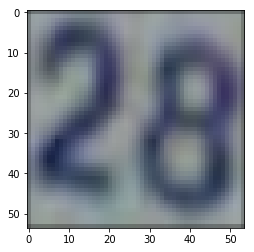

[0 1 0 0 0]
[[0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
[0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]


In [5]:
#Confirm Data
d=6135
plt.imshow(trainImageData[d]*255)
plt.show()
print(trainImageLengths[d])
print(trainImageDigits[d])

trainDigit0  = trainImageDigits[:,0,:]
trainDigit1  = trainImageDigits[:,1,:]
trainDigit2  = trainImageDigits[:,2,:]
trainDigit3  = trainImageDigits[:,3,:]
trainDigit4  = trainImageDigits[:,4,:]

print(trainDigit0[d])
print(trainDigit1[d])
print(trainDigit2[d])
print(trainDigit3[d])
print(trainDigit4[d])

In [6]:
inputSize=imgSize*imgSize
channels=3
num_labels=5

def getCnnModel():
    x = Input(batch_shape=(None, imgSize, imgSize,channels))

    conv = Convolution2D(64, (5, 5), strides=(1, 1), padding='same', name = "conv1", activation='relu')(x)
    conv = MaxPooling2D(pool_size = (2,2))(conv)
    conv = BatchNormalization()(conv)
    conv = Dropout(0.2)(conv)

    conv = Convolution2D(128, (5, 5), strides=(1, 1), padding='same', name = "conv2", activation='relu')(conv)
    conv = MaxPooling2D(pool_size = (2,2))(conv)
    conv = BatchNormalization()(conv)
    conv = Dropout(0.2)(conv)

    conv = Convolution2D(256, (5, 5), strides=(1, 1),padding='same', name = "conv3", activation='relu')(conv)
    conv = MaxPooling2D(pool_size = (2,2))(conv)
    conv = BatchNormalization()(conv)
    conv = Dropout(0.2)(conv)

    conv = Convolution2D(1024, (5, 5), strides=(1, 1),padding='same', name = "conv4", activation='relu')(conv)
    conv = MaxPooling2D(pool_size = (2,2))(conv)
    conv = BatchNormalization()(conv)
    conv = Dropout(0.2)(conv)


    flat = Flatten()(conv)

    dense = Dense(1024, activation='relu')(flat)
    dense = BatchNormalization()(dense)
    dense = Dropout(0.3)(dense)
    dense = Dense(1024, activation='relu')(dense)
    dense = BatchNormalization()(dense)
    dense = Dropout(0.3)(dense)
    dense = Dense(1024, activation='relu')(dense)
    dense = BatchNormalization()(dense)
    dense = Dropout(0.3)(dense)
    
    outL = Dense(5)(dense)
    outL = Activation('softmax', name="Length")(outL)

    outD0 = Dense(10)(dense)
    outD0 = Activation('sigmoid', name="Digit0")(outD0)
    outD1 = Dense(10)(dense)
    outD1 = Activation('sigmoid', name="Digit1")(outD1)
    outD2 = Dense(10)(dense)
    outD2 = Activation('sigmoid', name="Digit2")(outD2)
    outD3 = Dense(10)(dense)
    outD3 = Activation('sigmoid', name="Digit3")(outD3)
    outD4 = Dense(10)(dense)
    outD4 = Activation('sigmoid', name="Digit4")(outD4)
    model = Model(input=x, output=[outL, outD0, outD1, outD2, outD3, outD4])
    return model

In [7]:
batch_size = 256
modelFile = '/home/carnd/data/svhn/model.h5'
force = True
epochs=25
if os.path.isfile(modelFile) is False or force==True:
    tbCallBack = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)


    #model = strongLengthBias()
    model = getCnnModel()
    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='nadam',
                  metrics=['accuracy'])

    trainDigit0  = trainImageDigits[:,0,:]
    trainDigit1  = trainImageDigits[:,1,:]
    trainDigit2  = trainImageDigits[:,2,:]
    trainDigit3  = trainImageDigits[:,3,:]
    trainDigit4  = trainImageDigits[:,4,:]

    validationDigit0  = validationImageDigits[:,0,:]
    validationDigit1  = validationImageDigits[:,1,:]
    validationDigit2  = validationImageDigits[:,2,:]
    validationDigit3  = validationImageDigits[:,3,:]
    validationDigit4  = validationImageDigits[:,4,:]


    model.fit(trainImageData, [trainImageLengths, trainDigit0, trainDigit1, trainDigit2, trainDigit3, trainDigit4], nb_epoch=epochs, batch_size=batch_size, validation_data=(validationImageData,[validationImageLengths,validationDigit0,validationDigit1,validationDigit2,validationDigit3,validationDigit4]), callbacks=[tbCallBack], verbose=2)
    model.save(modelFile)
else:
    print('Loading saved model')
    from keras.models import load_model
    model = load_model(modelFile)

testDigit0  = testImageDigits[:,0,:]
testDigit1  = testImageDigits[:,1,:]
testDigit2  = testImageDigits[:,2,:]
testDigit3  = testImageDigits[:,3,:]
testDigit4  = testImageDigits[:,4,:]

score = model.evaluate(testImageData, [testImageLengths, testDigit0, testDigit1, testDigit2, testDigit3, testDigit4], batch_size=32)
print('Test score:', score)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:29: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 54, 54, 3)     0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 54, 54, 64)    4864        input_1[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 27, 27, 64)    0           conv1[0][0]                      
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 27, 27, 64)    256         max_pooling2d_1[0][0]            
___________________________________________________________________________________________

KeyboardInterrupt: 